<h1><center> Klasifikator </center></h1>

 <center>
    <h1><center>Microsoft malware classification</center></h1>
    <i>Klasifikacija zlonamjernog softvera</i> 
    <br><br>
    PRIRODOSLOVNO MATEMATIČKI FAKULTET - MATEMATIČKI ODSJEK <br>
    <b>Lipanj 2020.</b> 
    <br><br>
    <i>Stanišić Matea, Škrabo Petra, Terzanović Mateja, Tolja Margarita</i>  
</center>

***

Potrebno je u anaconda prompt-u instalirati xgboost s:<br>
<code>conda install -c anaconda py-xgboost</code>

### Priprema

In [308]:
# potrebni paketi
import numpy as np
from numpy import mean
from numpy import std
from numpy import loadtxt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import pyplot
from IPython.core.pylabtools import figsize
from collections import Counter
import random

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, log_loss, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import class_weight

In [ ]:
# učitavanje svih značajki iz training skupa
features = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/merged_all_features.csv")

# učitavanje svih značajki iz testing skupa
features_test = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/merged_test_features.csv")

# učitavanje svih značajki iz training skupa
selected_features = pd.read_csv('feature_selection_cv5')

In [180]:
features.head()

,Id,Class,byte_1G_00,byte_1G_01,byte_1G_02,byte_1G_03,byte_1G_04,byte_1G_05,byte_1G_06,byte_1G_07,...,visualc,___security_cookie,assume,callvirtualalloc,exportedentry,hardware,hkey_current_user,hkey_local_machine,sp-analysisfailed,unableto
0,01kcPWA9K2BOxQeS5Rju,1,21091,1213,726,817,1257,625,550,523,...,0,0,0,0,0,0,0,0,0,0
1,04EjIdbPV5e1XroFOpiN,1,40030,1980,1226,1193,1971,1096,961,755,...,0,0,0,0,0,0,0,0,0,0
2,05EeG39MTRrI6VY21DPd,1,19419,955,693,656,832,463,370,510,...,0,0,0,0,0,0,0,0,0,0
3,05rJTUWYAKNegBk2wE8X,1,79568,6445,3143,2517,4982,1824,2125,2964,...,0,0,2,0,0,0,0,0,0,0
4,0AnoOZDNbPXIr2MRBSCJ,1,25791,1202,569,750,948,456,405,517,...,0,0,0,0,0,0,0,0,0,0


In [181]:
selected_features.head()

,Unnamed: 0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC100,PC101,PC102,PC103,PC104,PC105,PC106,PC107,PC108,PC109
0,0,2.758885,-4.815674,-4.096333,2.893119,-0.016949,1.489298,-0.917445,-0.154625,2.116624,...,-0.274711,-0.446083,-0.116583,0.306839,0.575130,-0.144894,-0.107258,0.008032,-0.116864,0.083622
1,1,6.134662,-0.169692,-3.905000,3.035733,0.640184,3.231605,-1.170238,-0.131043,1.789371,...,-0.460911,0.229723,-0.083208,0.657943,0.884249,-0.192932,0.606504,0.373321,-0.267877,-0.444894
2,2,4.059810,-3.441866,-3.402326,1.966009,-0.498861,3.190550,-0.307942,1.334257,1.602137,...,-0.478440,0.165971,-0.187721,-0.336234,-0.057554,0.532081,0.112597,0.226716,0.025902,0.230062
3,3,24.334193,24.624190,-2.402030,-2.457468,-7.806197,-11.639498,-1.542437,-7.717818,-1.286335,...,-0.626446,0.594472,-5.009640,-0.012198,-2.396363,2.214136,1.018487,-4.639328,2.057111,-2.315513
4,4,1.654627,-2.159101,-4.067454,0.906983,-1.385565,2.033060,2.029099,-0.506575,0.405023,...,-0.490275,-0.236857,-0.641590,0.546539,-0.247375,-0.278855,0.271770,-0.399150,-0.795818,0.933269


In [182]:
#razdvajanje kategorija značajki
one_gram_features = features.iloc[:,2:258]
metadata_bytes_features = features.iloc[:,258:260]
entropy_features = features.iloc[:,260:462]
image_features = features.iloc[:,462:514]
string_length_features = features.iloc[:,514:630]
metadata_asm_features = features.iloc[:,630:632]
symbols_features = features.iloc[:,632:639]
opcode_features = features.iloc[:,639:732]
reg_features = features.iloc[:,732:758]
section_features = features.iloc[:,758:782]
dd_features = features.iloc[:,782:806]
api_features = features.iloc[:,806:1600]
key_features = features.iloc[:,1600:1695]

### random forest



In [261]:
def random_forest(X_train, X_test, y_train):
    y_train = [int(x-1) for x in y_train]
    clf = RandomForestClassifier(n_estimators=50, n_jobs=4)
    clf.fit(X_train, y_train)
    pred_class = clf.predict(X_test)
    pred_prob = clf.predict_proba(X_test)
    
    return pred_class,pred_prob
    

### extra tree

In [262]:
def extra_tree(X_train, X_test, y_train):
    y_train = [int(x-1) for x in y_train]
    clf = ExtraTreesClassifier(n_estimators=50, n_jobs=4)
    param_grid = {
        'n_estimators': [200, 700],
        'max_features': ['auto', 'sqrt', 'log2']
    }
    clf.fit(X_train, y_train)
    pred_class = clf.predict(X_test)
    pred_prob = clf.predict_proba(X_test)
    
    return pred_class,pred_prob

### XGboost

In [300]:
def xgboost_basic(X_train, X_test, y_train):
    #postavljanje parametara 
    param = {
        'booster' : 'gbtree',
        'eval_metric' : 'logloss',
        'scale_pos_weight' : 1.0,
        'nthread' : 8,
        'bst:colsample_bytree' : 0.5,
        #'seed' = seed,
        'max_depth': 3,  # the maximum depth of each tree
        'eta': 0.3,  # the training step for each iteration
        'silent': 1,  # logging mode - quiet
        'objective': 'multi:softprob',  # error evaluation for multiclass training
        'num_class': 9}  # the number of classes that exist in this datset
    num_round = 50  # the number of training iterations
    
    #klase smanjujemo za 1 da budu unutar [0,num_class>
    y_train = [int(x-1) for x in y_train]
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)
    bst = xgb.train(param, dtrain, num_round)
    #preds predstavlja vjerojatnost pripadanja svakoj klasi, a best_preds predstavlja klasu, onu koja ima najveću vjerojatnost
    preds = bst.predict(dtest)
    best_preds = np.asarray([np.argmax(line) for line in preds])
    return best_preds, preds

In [335]:
def xgboost_weighted(X_train, X_test, y_train):
    class_weights = list(class_weight.compute_class_weight('balanced', np.unique(features['Class']),features['Class']))
    w_array = np.ones(y_train.shape[0], dtype = 'float')
    for i, val in enumerate(y_train):
        w_array[i] = class_weights[val-1]
        
    param = {
        'booster' : 'gbtree',
        'eval_metric' : 'logloss',
        'scale_pos_weight' : 1.0,
        'nthread' : 8,
        'bst:colsample_bytree' : 0.5,
        #'seed' = seed,
        'max_depth': 3,  # the maximum depth of each tree
        'eta': 0.3,  # the training step for each iteration
        'silent': 1,  # logging mode - quiet
        'objective': 'multi:softprob',  # error evaluation for multiclass training
        'num_class': 9}  # the number of classes that exist in this datset
    num_round = 50  # the number of training iterations
    
    
    y_train = [int(x-1) for x in y_train]
    
    dtrain = xgb.DMatrix(X_train, label=y_train, weight=w_array)
    dtest = xgb.DMatrix(X_test)
    bst = xgb.train(param, dtrain, num_round)
    
    preds = bst.predict(dtest)
    best_preds = np.asarray([np.argmax(line) for line in preds])
    return best_preds, preds

###  confusion matrix

In [274]:
#funkcija koja računa i crta matricu konfuzije
def make_and_plot_confusion_matrix(y_test, best_preds, title='Confusion matrix'):
    names = ['class 1', 'class 2','class 3', 'class 4', 'class 5','class 6', 'class 7', 'class 8', 'class 9']
    cm = confusion_matrix(y_test, best_preds)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    norm_conf = []
    for i in cm:
        a = 0
        tmp_arr = []
        a = sum(i, 0)
        for j in i:
            tmp_arr.append(float(j)/float(a))
        norm_conf.append(tmp_arr)

    fig = plt.figure(figsize(10, 10))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    
    res = ax.imshow(np.array(norm_conf), cmap=plt.cm.Blues,
                    interpolation='nearest')

    width = len(cm)
    height = len(cm[0])

    for x in range(width):
        for y in range(height):
            ax.annotate(str(format(round(cm[x][y], 2))), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.title(title)
    cb = fig.colorbar(res)
    plt.xticks(range(width), names)
    plt.yticks(range(height), names)

<br>
<br>

XGboost proveden na svim značajkama

Logloss:0.014680709184568097
Accuracy:0.994786875191659


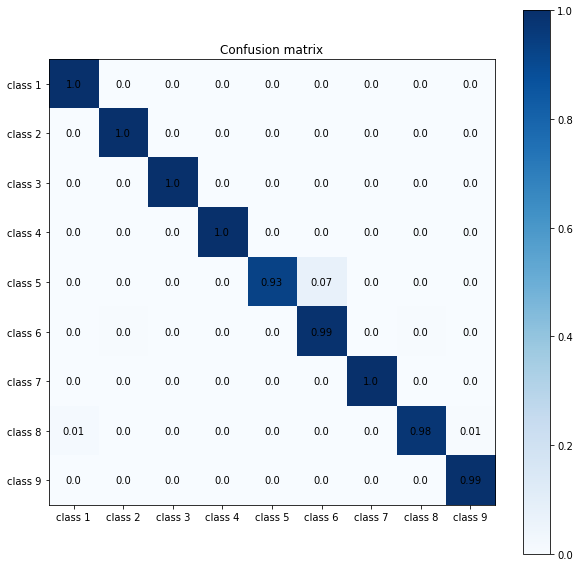

In [192]:
#xgboost na svim značajkama

#ovakav postupak se ponavlja puno puta pa je ovdje detaljnije komentiran
#prvo definiramo što nam je dataset i onda ga podijelimo na train i test
X=features.iloc[:,2:1695]
X_train, X_test, y_train, y_test = train_test_split( X, features['Class'], test_size=0.3, random_state=47)
#pozovemo funkciju koja nam vrati predictions, pred[0]=klasa, pred[1]=vjerojatnosti
pred = xgboost_basic(X_train, X_test, y_train)
#trebamo shift-ati klase i u y_test
y_test = [int(x-1) for x in y_test]
#računamo logloss(on uzima vjerojatnosti) i točnost(uzima klase)
score_log = log_loss(y_test,pred[1],eps=1e-15)
score_acc = accuracy_score(y_test, pred[0])
print('Logloss:' + str(score_log))
print('Accuracy:' + str(score_acc))
#matrici konfuzije šaljemo prave i predviđene klase skupa za testiranje
make_and_plot_confusion_matrix(y_test,pred[0])

In [281]:
def pomocna_fja(data):
    X_train, X_test, y_train, y_test = train_test_split( data, features['Class'], test_size=0.3, random_state=47)
    pred = xgboost_basic(X_train, X_test, y_train)
    y_test = [int(x-1) for x in y_test]
    score_log = log_loss(y_test,pred[1],eps=1e-15)
    score_acc = accuracy_score(y_test, pred[0])
    sve.append((score_log,score_acc))
    cm = confusion_matrix(y_test, pred[0])
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_diagonal.append(cm.diagonal())

In [282]:
#xgboost na svakoj kategoriji značajki posebno (samo informativno)
sve = []
cm_diagonal =[]

pomocna_fja(one_gram_features)
pomocna_fja(metadata_bytes_features)
pomocna_fja(entropy_features)
pomocna_fja(image_features)
pomocna_fja(string_length_features)
pomocna_fja(metadata_asm_features)
pomocna_fja(symbols_features)
pomocna_fja(opcode_features)
pomocna_fja(reg_features)
pomocna_fja(section_features)
pomocna_fja(dd_features)
pomocna_fja(api_features)
pomocna_fja(key_features)

In [283]:
#tablica rezultata
pd.DataFrame(sve, columns=['log_loss','accuracy_score'])

,log_loss,accuracy_score
0,0.062701,0.981907
1,0.456335,0.843606
2,0.054130,0.985894
3,0.108394,0.972094
4,0.082609,0.979148
5,0.330646,0.917203
6,0.169785,0.955535
7,0.031769,0.992640
8,0.083747,0.979454
9,1.915182,0.258203


In [284]:
#dijagonale pripadnih matrica konfizije
#iz toga možemo vidjeti točnost po klasama za svaku kategoriju feature-a
for list1 in cm_diagonal:
    for element in list1:
        print(str(format(round(element, 2))), end ="\t")
    print('')

0.99	0.99	1.0	0.95	0.71	0.95	0.99	0.94	0.99	
0.81	0.82	0.99	0.92	0.07	0.57	0.66	0.82	0.79	
0.99	0.99	1.0	0.98	0.5	0.97	0.99	0.95	1.0	
0.95	0.99	1.0	0.94	0.57	0.91	1.0	0.94	0.98	
0.97	0.98	1.0	1.0	0.5	0.96	1.0	0.94	0.99	
0.88	0.93	0.99	0.78	0.14	0.82	0.89	0.85	0.95	
0.92	0.96	1.0	0.92	0.5	0.92	0.94	0.92	0.98	
1.0	0.99	1.0	1.0	0.79	0.98	1.0	0.97	1.0	
0.96	0.99	1.0	0.98	0.64	0.96	0.97	0.95	0.99	
0.04	0.3	0.64	0.0	0.0	0.02	0.01	0.01	0.01	
0.03	0.27	0.7	0.0	0.0	0.01	0.01	0.02	0.01	
1.0	1.0	1.0	0.99	0.5	0.97	0.93	0.92	1.0	
0.99	1.0	1.0	1.0	0.86	0.98	1.0	0.98	0.99	


### selektirane značajke <br>

Logloss:0.05006839592836761
Accuracy:0.9871205151793928


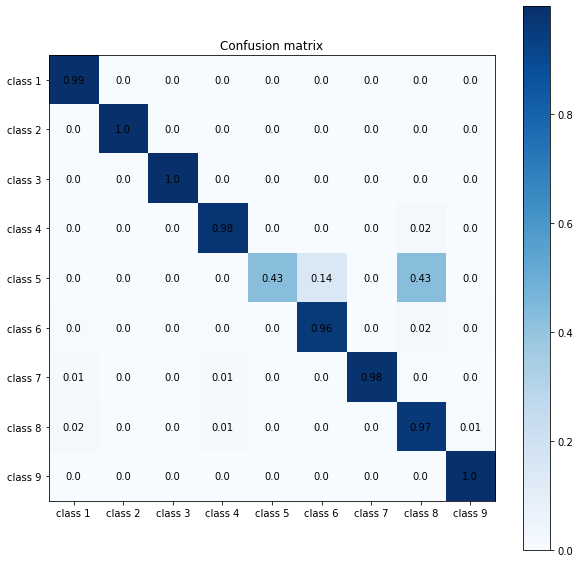

In [297]:
#xgboost na selektiranim značajkama
X=selected_features.iloc[:,1:110]
X_train, X_test, y_train, y_test = train_test_split( X, features['Class'], test_size=0.3, random_state=47)
pred = xgboost_basic(X_train, X_test, y_train)

y_test = [int(x-1) for x in y_test]
score_log = log_loss(y_test,pred[1],eps=1e-15)
score_acc = accuracy_score(y_test, pred[0])

print('Logloss:' + str(score_log))
print('Accuracy:' + str(score_acc))

make_and_plot_confusion_matrix(y_test,pred[0])

## Pokušaji rješavanja nebalasiranosti podataka

### dodavanje težina u XGboost

Logloss:0.05028339690523794
Accuracy:0.984360625574977


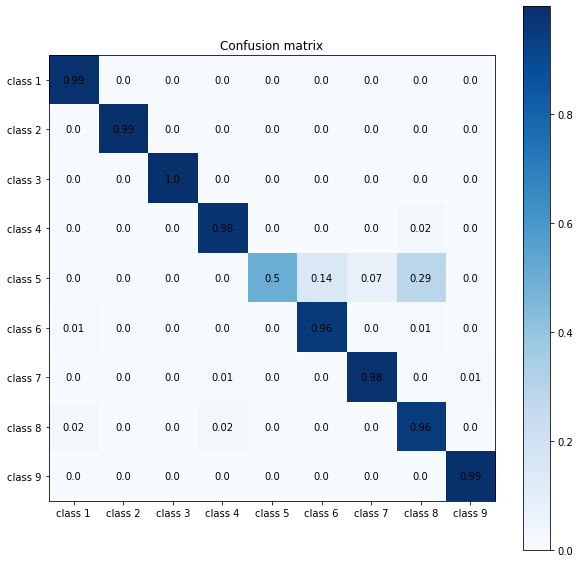

In [292]:
#xgboost sa dodanim težinama
X=selected_features.iloc[:,1:110]
X_train, X_test, y_train, y_test = train_test_split( X, features['Class'], test_size=0.3, random_state=47)
pred = xgboost_weighted(X_train, X_test, y_train)

y_test = [int(x-1) for x in y_test]
score_log = log_loss(y_test,pred[1],eps=1e-15)
score_acc = accuracy_score(y_test, pred[0])

print('Logloss:' + str(score_log))
print('Accuracy:' + str(score_acc))

make_and_plot_confusion_matrix(y_test,pred[0])

### oversampling

[(1, 2008), (2, 2008), (3, 2008), (4, 2008), (5, 2008), (6, 2008), (7, 2008), (8, 2008), (9, 2008)]
Logloss:0.051979165193453754
Accuracy:0.9855872431769396


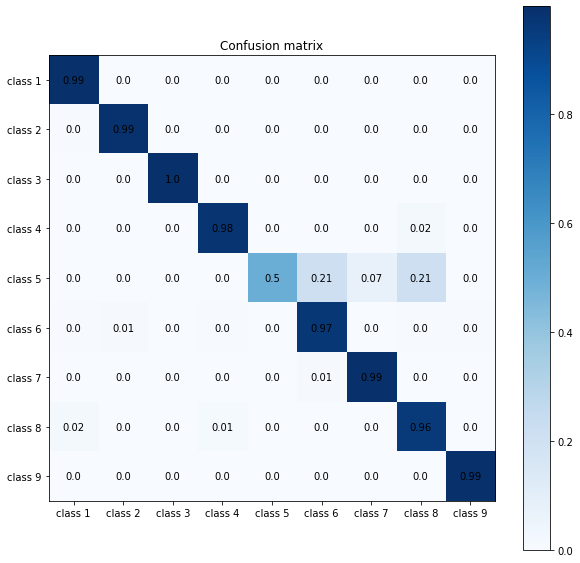

In [293]:
#RandomOverSampler
X=selected_features.iloc[:,1:110]
X_train, X_test, y_train, y_test = train_test_split( X, features['Class'], test_size=0.3, random_state=47)
ros = RandomOverSampler(random_state=0)
X_train, y_train = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))
pred = xgboost_basic(X_train, X_test, y_train)

y_test = [int(x-1) for x in y_test]
score_log = log_loss(y_test,pred[1],eps=1e-15)
score_acc = accuracy_score(y_test, pred[0])

print('Logloss:' + str(score_log))
print('Accuracy:' + str(score_acc))

make_and_plot_confusion_matrix(y_test,pred[0])

[(1, 2008), (2, 2008), (3, 2008), (4, 2008), (5, 2008), (6, 2008), (7, 2008), (8, 2008), (9, 2008)]
Logloss:0.048039368658470666
Accuracy:0.9855872431769396


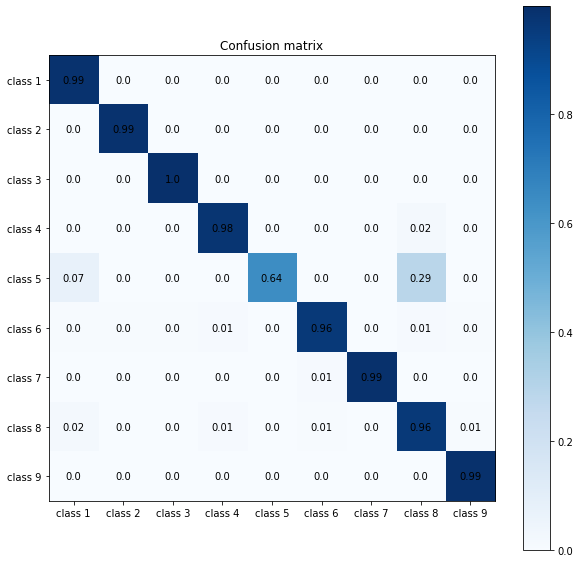

In [295]:
#SMOTE
X=selected_features.iloc[:,1:110]
X_train, X_test, y_train, y_test = train_test_split( X, features['Class'], test_size=0.3, random_state=47)
X_train, y_train = SMOTE().fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))

pred = xgboost_basic(X_train, X_test, y_train)

y_test = [int(x-1) for x in y_test]
score_log = log_loss(y_test,pred[1],eps=1e-15)
score_acc = accuracy_score(y_test, pred[0])

print('Logloss:' + str(score_log))
print('Accuracy:' + str(score_acc))

make_and_plot_confusion_matrix(y_test,pred[0])


[(1, 2008), (2, 2008), (3, 2008), (4, 2008), (5, 2008), (6, 2008), (7, 2008), (8, 2008), (9, 2008)]
Logloss:0.045656025243421355
Accuracy:0.9889604415823368


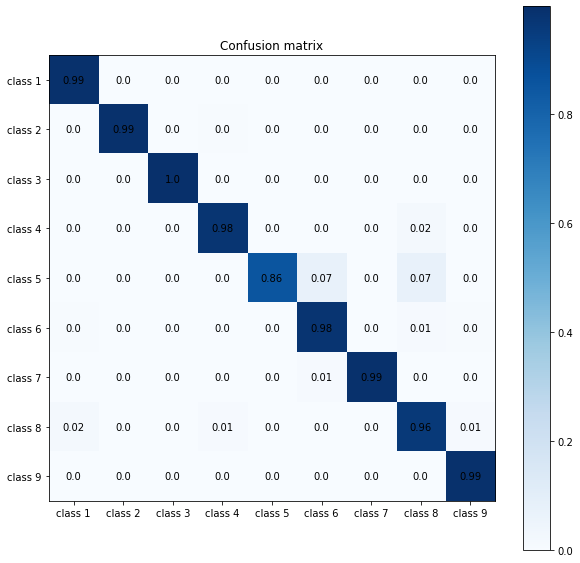

In [334]:
#SMOTE+težine
X=selected_features.iloc[:,1:110]
X_train, X_test, y_train, y_test = train_test_split( X, features['Class'], test_size=0.3, random_state=47)
X_train, y_train = SMOTE().fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))

pred = xgboost_weighted(X_train, X_test, y_train)

y_test = [int(x-1) for x in y_test]
score_log = log_loss(y_test,pred[1],eps=1e-15)
score_acc = accuracy_score(y_test, pred[0])

print('Logloss:' + str(score_log))
print('Accuracy:' + str(score_acc))

make_and_plot_confusion_matrix(y_test,pred[0])

[(1, 1993), (2, 2007), (3, 2008), (4, 2006), (5, 2002), (6, 2010), (7, 2011), (8, 2020), (9, 2016)]
Logloss:0.052252226398231745
Accuracy:0.9862005519779209


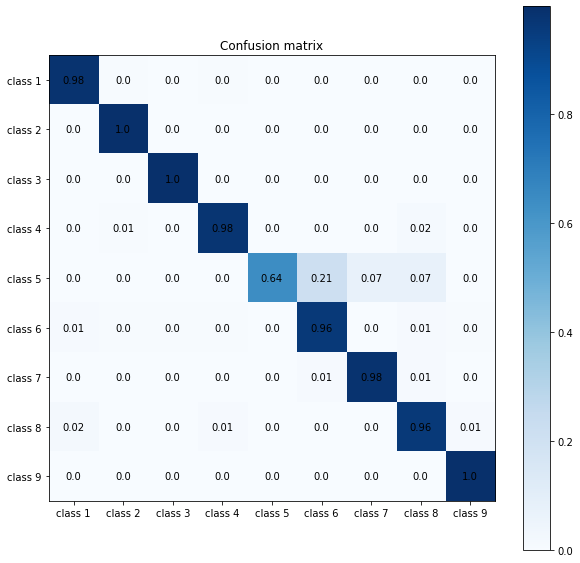

In [296]:
#ADASYN
X=selected_features.iloc[:,1:110]
X_train, X_test, y_train, y_test = train_test_split( X, features['Class'], test_size=0.3, random_state=47)
X_train, y_train = ADASYN().fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))

pred = xgboost_basic(X_train, X_test, y_train)

y_test = [int(x-1) for x in y_test]
score_log = log_loss(y_test,pred[1],eps=1e-15)
score_acc = accuracy_score(y_test, pred[0])

print('Logloss:' + str(score_log))
print('Accuracy:' + str(score_acc))

make_and_plot_confusion_matrix(y_test,pred[0])

[(1, 1993), (2, 2007), (3, 2008), (4, 2006), (5, 2002), (6, 2010), (7, 2011), (8, 2020), (9, 2016)]
Logloss:0.05918846215967971
Accuracy:0.984360625574977


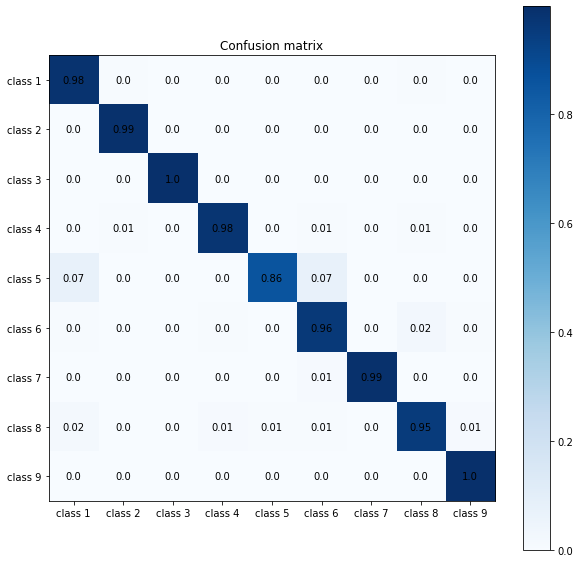

In [324]:
#ADASYN+težine
X=selected_features.iloc[:,1:110]
X_train, X_test, y_train, y_test = train_test_split( X, features['Class'], test_size=0.3, random_state=47)
X_train, y_train = ADASYN().fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))

pred = xgboost_weighted(X_train, X_test, y_train)

y_test = [int(x-1) for x in y_test]
score_log = log_loss(y_test,pred[1],eps=1e-15)
score_acc = accuracy_score(y_test, pred[0])

print('Logloss:' + str(score_log))
print('Accuracy:' + str(score_acc))

make_and_plot_confusion_matrix(y_test,pred[0])

### undersample

[(1, 1085), (2, 1747), (3, 28), (4, 343), (5, 28), (6, 548), (7, 276), (8, 845), (9, 726)]
Logloss:0.08675322840051371
Accuracy:0.9763876111622202


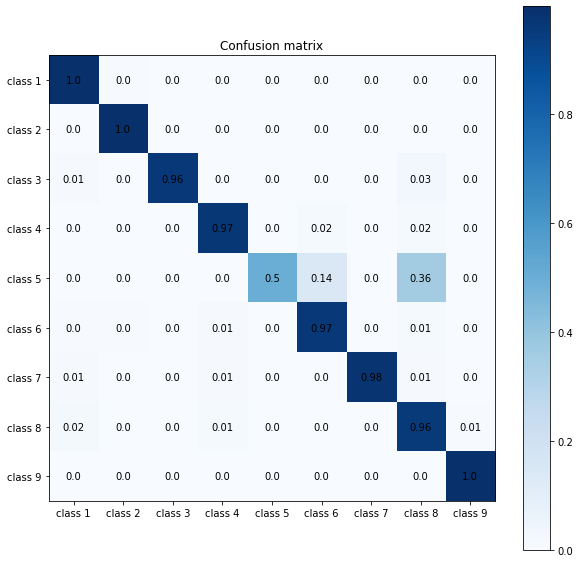

In [301]:
#RandomUnderSampler
X=selected_features.iloc[:,1:110]
X_train, X_test, y_train, y_test = train_test_split( X, features['Class'], test_size=0.3, random_state=47)
undersample = RandomUnderSampler(sampling_strategy='majority')
X_train, y_train = undersample.fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))

pred = xgboost_basic(X_train, X_test, y_train)

y_test = [int(x-1) for x in y_test]
score_log = log_loss(y_test,pred[1],eps=1e-15)
score_acc = accuracy_score(y_test, pred[0])

print('Logloss:' + str(score_log))
print('Accuracy:' + str(score_acc))

make_and_plot_confusion_matrix(y_test,pred[0])

## bagging

Logloss:0.11550571770783458
Accuracy:0.9809874271695799


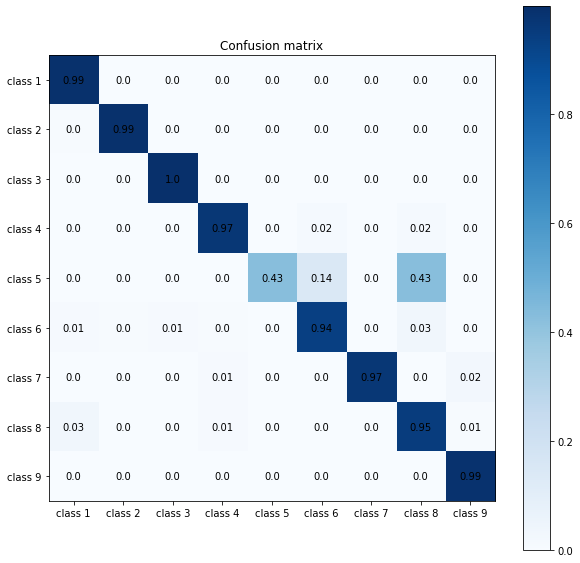

In [304]:
#BaggingClassifier iz sklearn-a, ali čini mi se da moramo koristit XGBClassifier()

X=selected_features.iloc[:,1:110]
X_train, X_test, y_train, y_test = train_test_split( X, features['Class'], test_size=0.3, random_state=47)

param = {
    'n_estimators':50,
    'booster' : 'gbtree',
    'eval_metric' : 'logloss',
    'scale_pos_weight' : 1.0,
    'nthread' : 8,
    'bst:colsample_bytree' : 0.5,
    #'seed' = seed,
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 9}  # the number of classes that exist in this datset
exgb_classifier = xgb.XGBClassifier()
exgb_classifier.set_params(**param)

y_train = [int(x-1) for x in y_train]
y_test = [int(x-1) for x in y_test]

model = BaggingClassifier(base_estimator=exgb_classifier,n_estimators=10, random_state=0, n_jobs=-1).fit(X_train, y_train)

pred=model.predict(X_test)
pred_prob=model.predict_proba(X_test)

score_log = log_loss(y_test,pred_prob,eps=1e-15)
score_acc = accuracy_score(y_test, pred)

print('Logloss:' + str(score_log))
print('Accuracy:' + str(score_acc))

make_and_plot_confusion_matrix(y_test,pred)

### ručni kvazi-bagging

In [328]:
def bagging_custom(n_bags, test_index, train_index, train_X, test_X, train_y):
    
    bags = n_bags#broj bag-ova
    test_pred_prob = np.zeros((len(test_index),9))
    for bg in range(bags):
        #new_train_index je prvo samo izmješani train_index
        new_train_index = random.sample(list(train_index), int(len(train_index) * 1.))
        #dodajemo mi nasumične brojeve iz train_index (s ponavljanjem)
        for i in range(int(len(train_index) * 1.)):
            new_train_index.append(random.choice(train_index))

        train_X=X.iloc[new_train_index,:]
        train_y=y.iloc[new_train_index]

        #pred = xgboost_basic(train_X, test_X, train_y)
        #SMOTE+težine
        X_train, y_train = SMOTE().fit_resample(train_X, train_y)
        pred = xgboost_weighted(X_train, test_X, y_train)      
        

        print("Bag " + str(bg+1))
        
        #zbrajamo vjerojatnosti od svih bag-ova
        test_pred_prob += pred[1]
    #izračunamo prosječne vjerojatnosti pa onda klase
    pred_prob = test_pred_prob / bags
    best_preds = np.asarray([np.argmax(line) for line in pred_prob])
    return best_preds, pred_prob

### kfold

In [329]:
#kfold i bagging
X=selected_features.iloc[:,1:110]
y=features.iloc[:,1]
kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1000)

predicted = []
original = []
log_losses = []
accuracies = []
fold_counter = 0
misclassified_counter = 1
for train_index, test_index in kfold.split(X,y):
    fold_counter += 1
    train_X=X.iloc[train_index,:]
    train_y=y.iloc[train_index]
    test_X=X.iloc[test_index,:]
    test_y=y.iloc[test_index]
    
    pred = bagging_custom(10, test_index, train_index, train_X, test_X, train_y) 

    test_y = [int(x-1) for x in test_y]
    
    score_log = log_loss(test_y,pred[1],eps=1e-15)
    score_acc = accuracy_score(test_y, pred[0])

    log_losses.append(score_log)
    accuracies.append(score_acc)
    
    predicted.extend(pred[0])
    original.extend(test_y)
    
    print('-----------------------------------')
    print('FOLD '+ str(fold_counter))
    print('Logloss:' + str(score_log))
    print('Accuracy:' + str(score_acc))

    for i in range(len(pred[0])):
        if pred[0][i] != test_y[i]:
            print ('Missed! ' + 'actual='+str(test_y[i]+1) + ' predicted='+str(pred[0][i]+1))
            misclassified_counter += 1

predicted = np.array(predicted)
original = np.array(original)
print ('===========================================')
print('In total {} misclassified samples'.format(misclassified_counter-1))
print('Accuracy mean : ' + str(np.mean(accuracies)))
print('log loss mean : ' + str(np.mean(log_losses)))


Bag 1
Bag 2
Bag 3
Bag 4
Bag 5
Bag 6
Bag 7
Bag 8
Bag 9
Bag 10
-----------------------------------
FOLD 1
Logloss:0.026771350697545805
Accuracy:0.9935602575896965
Missed! actual=1 predicted=5
Missed! actual=2 predicted=1
Missed! actual=2 predicted=4
Missed! actual=8 predicted=1
Missed! actual=8 predicted=1
Missed! actual=8 predicted=1
Missed! actual=9 predicted=8


KeyboardInterrupt: 

### stacking

>rfc 0.984 (0.002)
>etc 0.984 (0.002)
>xgb 0.976 (0.003)


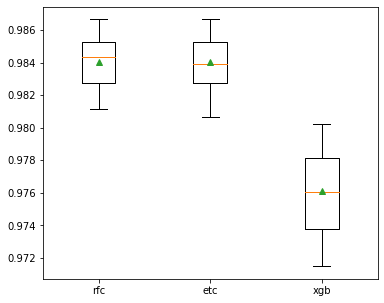

In [305]:
#prvo, evaluacija svakog modela kojeg ćemo koristiti u stackingu posebno

#lista modela
def get_models():
    models = dict()
    models['rfc'] = RandomForestClassifier(n_estimators=50, n_jobs=4)
    models['etc'] = ExtraTreesClassifier(n_estimators=50, n_jobs=4)
    param = {
        'n_estimators':50,
        'booster' : 'gbtree',
        'eval_metric' : 'logloss',
        'scale_pos_weight' : 1.0,
        'nthread' : 8,
        'bst:colsample_bytree' : 0.5,
        #'seed' = seed,
        'max_depth': 3,  # the maximum depth of each tree
        'eta': 0.3,  # the training step for each iteration
        'silent': 1,  # logging mode - quiet
        'objective': 'multi:softprob',  # error evaluation for multiclass training
        'num_class': 9}  # the number of classes that exist in this datset
    models['xgb'] =xgb.XGBClassifier(**param)
    return models
 
# evaluacija modela s cross-validation
def evaluate_model(model):
    X=selected_features.iloc[:,1:110]
    y=features.iloc[:,1]
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores


models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# boxplot točnosti
fig = plt.subplots(figsize=(6, 5))
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [247]:
# stacking
def get_stacking():
    # level0 je base models
    level0 = list()
    level0.append(('rfc', RandomForestClassifier(n_estimators=50, n_jobs=4)))
    level0.append(('etc', ExtraTreesClassifier(n_estimators=50, n_jobs=4)))
    param = {
        'n_estimators':50,
        'booster' : 'gbtree',
        'eval_metric' : 'logloss',
        'scale_pos_weight' : 1.0,
        'nthread' : 8,
        'bst:colsample_bytree' : 0.5,
        #'seed' = seed,
        'max_depth': 3,  # the maximum depth of each tree
        'eta': 0.3,  # the training step for each iteration
        'silent': 1,  # logging mode - quiet
        'objective': 'multi:softprob',  # error evaluation for multiclass training
        'num_class': 9}  # the number of classes that exist in this datset
    level0.append(('xgb', xgb.XGBClassifier(**param)))
    # level1 je learner model
    level1 = LogisticRegression()
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

X=selected_features.iloc[:,1:110]
X_train, X_test, y_train, y_test = train_test_split( X, features['Class'], test_size=0.3, random_state=47)
y_train = [int(x-1) for x in y_train]
y_test = [int(x-1) for x in y_test]

model=get_stacking()
model.fit(X_train, y_train)

pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)
score_log = log_loss(y_test,pred_proba,eps=1e-15)
score_acc = accuracy_score(y_test, pred)

print('Logloss:' + str(score_log))
print('Accuracy:' + str(score_acc))
make_and_plot_confusion_matrix(y_test,pred)

KeyboardInterrupt: 

### cross-validation za xgboost koristeći xgb.cv

In [199]:
#cross-validation s xgboost-om koristeći xgb.cv
X=selected_features.iloc[:,1:110]
X_train, X_test, y_train, y_test = train_test_split( X, features['Class'], test_size=0.3, random_state=47)
param = {
    'booster' : 'gbtree',
    'eval_metric' : 'mlogloss',
    'scale_pos_weight' : 1.0,
    'nthread' : 8,
    'bst:colsample_bytree' : 0.5,
    #'seed' = seed,
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 9}  # the number of classes that exist in this datset
num_round = 50  # the number of training iterations
y_train = [int(x-1) for x in y_train]

dtrain = xgb.DMatrix(X_train, label=y_train)

res = xgb.cv(param, dtrain, num_round, nfold=5, early_stopping_rounds=10, show_stdv=True)

best_nrounds = res.shape[0] - 1
cv_mean = res.iloc[-1, 0]
cv_std = res.iloc[-1, 1]

print('mean %.3f scores %.3f' % (cv_mean, cv_std))

### testiranje parametara?

In [319]:
model_XGB = xgb.XGBClassifier()

In [320]:
# define the parameter values that should be searched
n_estimators_range = list(range(1, 201))
learning_range = list(range(1, 31))
learning_range = [x / 10 for x in learning_range]
depth_range = list(range(1, 101))
child_weight_range = list(range(1, 31))
child_weight_range = [x / 10 for x in child_weight_range]
max_delta_step_range = list(range(1, 10))
scale_pos_weight_range = list(range(1, 10))
scale_pos_weight_range.append(0.5)
scale_pos_weight_range.append(0.6)
scale_pos_weight_range.append(0.7)
scale_pos_weight_range.append(0.8)
scale_pos_weight_range.append(0.9)
base_score_range = list(range(5, 10))
base_score_range = [x / 10 for x in base_score_range]
subsample_range = list(range(1, 10))
subsample_range = [x / 10 for x in subsample_range]
colsample_bytree_range = list(range(1, 10))
colsample_bytree_range = [x / 10 for x in colsample_bytree_range]
colsample_bylevel_range = list(range(1, 10))
colsample_bylevel_range = [x / 10 for x in colsample_bylevel_range]

In [314]:
# specify "parameter distributions" rather than a "parameter grid"
# for unmentioned parameters we use default values in our model
param_dist_XGB = dict(learning_rate = learning_range,
                      max_depth=depth_range,
                      base_score=base_score_range)

In [321]:
# we use the RandomizedSearchCV to find the best parameters for our XGB model
rand_XGB = RandomizedSearchCV(model_XGB, param_dist_XGB, cv=10, scoring='accuracy', n_iter=20, random_state=5, return_train_score=False)


In [322]:
X=selected_features.iloc[:,1:110]
y=features.iloc[:,1]
rand_XGB.fit(X, y)
pd.DataFrame(rand_XGB.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

KeyboardInterrupt: 

<br>
<br>
<br>
.........fails..........

In [249]:
#fail izrade bootstrap replike
X=selected_features.iloc[:,1:110]
y=features.iloc[:,1]
# scikit-learn bootstrap
from sklearn.utils import resample
# data sample
data = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
# prepare bootstrap sample
y_train = resample(y, replace=True, n_samples=8000, random_state=1)
# out of bag observations
y_test = [x for x in y if x not in y_train]
X_train=X.iloc[y_train,:]
X_test=X.iloc[y_test,:]

pred = xgboost_basic(X_train, X_test, y_train)

y_test = [int(x-1) for x in y_test]
score_log = log_loss(y_test,pred[1],eps=1e-15)
score_acc = accuracy_score(y_test, pred[0])

print('Logloss:' + str(score_log))
print('Accuracy:' + str(score_acc))

make_and_plot_confusion_matrix(y_test,pred[0])

ValueError: y_true and y_pred contain different number of classes 4, 9. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [3 4 5 6]

In [193]:
#neki sneaky trik za navodno smanjih logloss, al se poveća...?
pred_clipped = np.clip(pred[1], 0.025, 0.975)
score_log = log_loss(y_test,pred_clipped,eps=1e-15)
print('Logloss:' + str(score_log))

Logloss:0.1977573783850604


In [58]:
#ručno računanje težina (jer mi nešto nije funkcioniralo)
#wj=ukupan_broj_primjera/(broj_primjera_u_klasi*broj_klasa)
#prvo izračunamo težine klasa, a onda ih pridružimo svakom primjeru
#tj. u sample data se nalaze težine svakog primjera iz y_train
def create_weights(y_train, largest_class_weight_coef):
    classes = np.unique(y_train, axis = 0)
    classes.sort()
    class_samples = np.bincount(y_train)
    total_samples = class_samples.sum()
    n_classes = len(class_samples)
    weights = total_samples / (n_classes * class_samples * 1.0)
    class_weight_dict = {key : value for (key, value) in zip(classes, weights)}
    sample_weights = [class_weight_dict[y] for y in y_train]
    return sample_weights